In [43]:
import json
import matplotlib.pyplot as plt
import os

def find_neg_ratio(values: list):
    total_count = len(values)
    negative_count = sum(1 for x in values if x < 0)

    # Step 3: Calculate the ratio
    negative_ratio = negative_count / total_count if total_count > 0 else 0
    return negative_ratio

root_dir = os.getcwd()
result_dict = json.load(open(f'{root_dir}/preference_data/turn_level_preference_openmodel_Llama-3.2-1B-Instruct_lora_top50_2_history_opendialkg_eval_full_non_repeated.json'))
# result_dict = json.load(open(f'{root_dir}/preference_data/turn_level_preference_openmodel_Llama-3.2-1B-Instruct_top50_2_history_opendialkg_eval_full_non_repeated.json'))
# result_dict = json.load(open(f'{root_dir}/preference_data/turn_level_preference_chatgpt_opendialkg_eval_full_non_repeated.json'))
# result_dict = json.load(open(f'{root_dir}/preference_data/turn_level_preference_openmodel_Llama-3.2-1B-Instruct_top50_2_history_opendialkg_eval_full_non_repeated.json'))
# metric = "consine_sim_above_avg"
metric = "cosine_sim_above_avg"
succ_count = 0
fail_count = 0
turn_level_SR = {1: {'sucess': 0, 'fail': 0}, 2: {'sucess': 0, 'fail': 0}, 3: {'sucess': 0, 'fail': 0}, 4: {'sucess': 0, 'fail': 0}, 5: {'sucess': 0, 'fail': 0}}
frequency = {1: [], 2: [], 3: [], 4: [], 5: []}
for key, value in result_dict.items():
    if len(value) == 1:
        continue
    if value[0]['rec_success']: 
        succ_count += 1
        turn_level_SR[len(value)-1]['sucess'] += 1
    else: 
        fail_count += 1
        turn_level_SR[len(value)-1]['fail'] += 1
    length = len(value) - 1
    if length == 0:
        continue
    frequency[length].append(value)
    
# print(f'total: {succ_count + fail_count}')
print(f'total: {succ_count + fail_count}, success_rate: {succ_count / (succ_count + fail_count):.3f}')

for turn_num in range(1,6):
    print(f'turn_num: {turn_num}, freq: {len(frequency[turn_num])}, success_rate: {turn_level_SR[turn_num]["sucess"] / (turn_level_SR[turn_num]["sucess"] + turn_level_SR[turn_num]["fail"]):.3f}')

total: 789, success_rate: 0.119
turn_num: 1, freq: 18, success_rate: 1.000
turn_num: 2, freq: 20, success_rate: 1.000
turn_num: 3, freq: 20, success_rate: 1.000
turn_num: 4, freq: 20, success_rate: 0.950
turn_num: 5, freq: 711, success_rate: 0.024


In [44]:
turn_level_data_dict = {turn_num: [] for turn_num in range(1,6)}
for turn_num in range(1,6):
    for data in frequency[turn_num]:
        turn_level_data_dict[turn_num].append([x[metric] for x in data])

In [45]:
import torch
for turn_num in range(1,6):
    turn_data = torch.tensor(turn_level_data_dict[turn_num])
    size = turn_data.size(0)
    turn_data = turn_data.mean(dim=0)
    print(f'size: {size}, mean: {turn_data}')

size: 18, mean: tensor([0.2222, 0.2532])
size: 20, mean: tensor([0.1581, 0.2192, 0.2089])
size: 20, mean: tensor([0.1944, 0.2456, 0.2726, 0.2041])
size: 20, mean: tensor([0.1742, 0.2140, 0.2462, 0.2477, 0.1921])
size: 711, mean: tensor([0.1686, 0.2178, 0.2433, 0.2448, 0.2410, 0.1891])


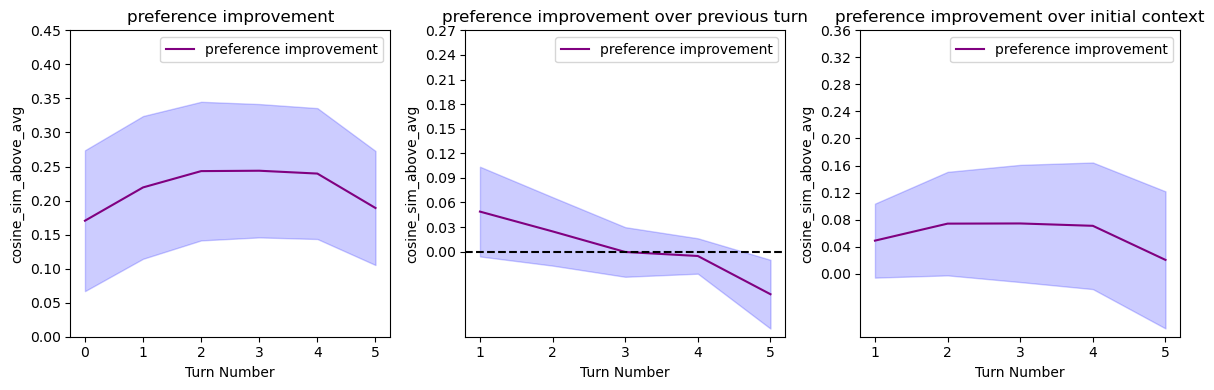

In [46]:
# get diff
colors = ['blue', 'green', 'red', 'orange']
key_list = [metric]

pref_dict = {key: {idx: [] for idx in range(0,6)} for key in key_list}
diff_dict = {key: {idx: [] for idx in range(1,6)} for key in key_list}
diff_from_base = {key: {idx: [] for idx in range(1,6)} for key in key_list}

for total_turn in range(1, 6):
    for result in frequency[total_turn]:
        for idx in range(1, total_turn+1):
            for key in key_list:
                if idx == 1:
                    pref_dict[key][idx-1].append(result[idx-1][key])
                pref_dict[key][idx].append(result[idx][key])
                diff_dict[key][idx].append(result[idx][key] - result[idx-1][key])
                diff_from_base[key][idx].append(result[idx][key] - result[0][key])

# plot diff
import statistics

num_keys = len(key_list)
rows = 1  # Adjust rows to accommodate all keys
cols = 3  # Choose 2 columns for better layout
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
x_value = list(range(1, total_turn + 1))

ax = axes[0]
total_turn = 5
key = metric
std = [statistics.stdev(pref_dict[key][turn]) for turn in range(0, total_turn + 1)]
key_data = [statistics.mean(pref_dict[key][turn]) for turn in range(0, total_turn + 1)]
key_data_plus_std = [key_data[i] + std[i] for i in range(len(key_data))]
key_data_minus_std = [key_data[i] - std[i] for i in range(len(key_data))]
x_value = list(range(0, total_turn + 1))
ax.set_xticks(x_value)
ax.plot(x_value, key_data, label=f'preference improvement', color = 'purple')  # Plot data on the axis
ax.fill_between(x_value, key_data_minus_std, key_data_plus_std, 
                color='blue', alpha=0.2)
ax.set_xlabel('Turn Number')
ax.set_ylabel(f'{key}')
ax.set_title(f'preference improvement')

# ax.set_yticks([0.05 * idx for idx in range(15)])
ax.set_yticks([0.05 * idx for idx in range(10)])
ax.legend()


ax = axes[1]
x_value = list(range(1, total_turn + 1))
std = [statistics.stdev(diff_dict[key][turn]) for turn in range(1, total_turn + 1)]
key_data = [statistics.mean(diff_dict[key][turn]) for turn in range(1, total_turn + 1)]
key_data_plus_std = [key_data[i] + std[i] for i in range(len(key_data))]
key_data_minus_std = [key_data[i] - std[i] for i in range(len(key_data))]
ax.plot(x_value, key_data, label=f'preference improvement', color = 'purple')  # Plot data on the axis
ax.axhline(y=0, color='black', linestyle='--')
ax.fill_between(x_value, key_data_minus_std, key_data_plus_std, 
                color='blue', alpha=0.2)
ax.set_xlabel('Turn Number')
ax.set_ylabel(f'{key}')
ax.set_title(f'preference improvement over previous turn')
ax.set_xticks(x_value)
ax.set_yticks([0.03 * idx for idx in range(10)])
ax.legend()

ax = axes[2]
std = [statistics.stdev(diff_from_base[key][turn]) for turn in range(1, total_turn + 1)]
key_data = [statistics.mean(diff_from_base[key][turn]) for turn in range(1, total_turn + 1)]
key_data_plus_std = [key_data[i] + std[i] for i in range(len(key_data))]
key_data_minus_std = [key_data[i] - std[i] for i in range(len(key_data))]
ax.plot(x_value, key_data, label=f'preference improvement', color = 'purple')  # Plot data on the axis
ax.fill_between(x_value, key_data_minus_std, key_data_plus_std, 
                color='blue', alpha=0.2)

ax.legend()
ax.set_xlabel('Turn Number')
ax.set_ylabel(f'{key}')
ax.set_title(f'preference improvement over initial context')
ax.set_xticks(x_value)
ax.set_yticks([0.04 * idx for idx in range(10)])

# Hide any unused subplots
# for extra_ax in axes[num_keys:]:
#     extra_ax.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

In [47]:
real_diff_list = []
real_diff_dict = {idx: [] for idx in range(1,6)}
for total_turn in range(1, 6):
    for result in frequency[total_turn]:
        for idx in range(1, total_turn+1):
            for key in key_list:
                if idx == total_turn and result[idx]['rec_success']:
                    pass
                else:
                    real_diff_dict[idx].append(result[idx][key] - result[idx-1][key])
                    real_diff_list.append(result[idx][key] - result[idx-1][key])

useful_turn_ratio: 0.485, unuseful_turn_ratio: 0.515


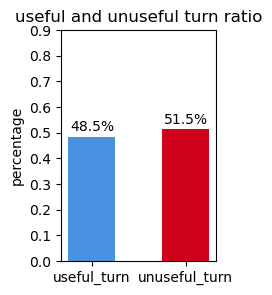

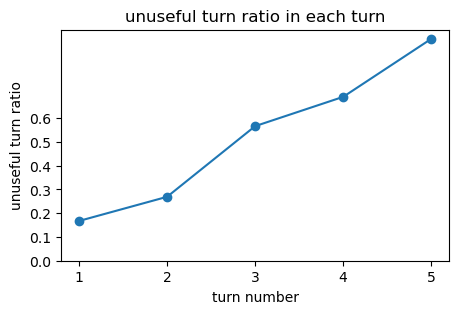

In [48]:
# count the ratio of negative diff in real_diff_list
turn_level_unuseful_turn_ratio = {idx: find_neg_ratio(real_diff_dict[idx]) for idx in range(1,6)}
unuseful_turn_ratio = find_neg_ratio(real_diff_list)
useful_turn_ratio = 1 - unuseful_turn_ratio

print(f'useful_turn_ratio: {useful_turn_ratio:.3f}, unuseful_turn_ratio: {unuseful_turn_ratio:.3f}')

plt.figure(figsize=(2, 3))
# show bar graph of useful and unuseful turn
x = ['useful_turn', 'unuseful_turn']
y = [useful_turn_ratio, unuseful_turn_ratio]
colors = ['#4A90E2', '#D0021B'] 
bars = plt.bar(x, y, width=0.5, color = colors)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
             bar.get_height() + 0.01,            # Y-coordinate (slightly above the bar)
             f'{bar.get_height()*100:.1f}%',         # The value (formatted as one decimal)
             ha='center',                       # Horizontal alignment
             va='bottom',                       # Vertical alignment
             fontsize=10,                       # Font size
             color='black')                     # Text color
    
plt.ylabel('percentage')
plt.title('useful and unuseful turn ratio')
plt.yticks([0.1 * idx for idx in range(10)])
plt.show()

# show line graph of unuseful turn ratio
plt.figure(figsize=(5, 3))
x = list(range(1,6))
y = [turn_level_unuseful_turn_ratio[idx] for idx in range(1,6)]
plt.plot(x, y, marker='o')
plt.xlabel('turn number')
plt.ylabel('unuseful turn ratio')
plt.title('unuseful turn ratio in each turn')
plt.xticks(x)
plt.yticks([0.1 * idx for idx in range(7)])
plt.show()

In [49]:
# statistics.mean(pref_dict['consine_sim_above_avg'][0])
key = 'consine_sim_above_avg'
for idx in range(1,6):
    print(statistics.mean(diff_dict[key][idx]))
    print(statistics.mean(pref_dict[key][idx]) - statistics.mean(pref_dict[key][idx-1]))
    # print(statistics.mean(pref_dict[key][idx]) - statistics.mean(pref_dict[key][0]))
    print("=================")

KeyError: 'consine_sim_above_avg'

In [ ]:
# get diff

def find_neg_ratio(values: list):
    total_count = len(values)
    negative_count = sum(1 for x in values if x < 0)

    # Step 3: Calculate the ratio
    negative_ratio = negative_count / total_count if total_count > 0 else 0
    return negative_ratio

colors = ['blue', 'green', 'red', 'orange']
key_list = ['consine_sim_above_avg']

pref_dict_pos = {key: {idx: [] for idx in range(0,6)} for key in key_list}
diff_dict_pos = {key: {idx: [] for idx in range(1,6)} for key in key_list}
diff_from_base_pos = {key: {idx: [] for idx in range(1,6)} for key in key_list}

pref_dict_neg = {key: {idx: [] for idx in range(0,6)} for key in key_list}
diff_dict_neg = {key: {idx: [] for idx in range(1,6)} for key in key_list}
diff_from_base_neg = {key: {idx: [] for idx in range(1,6)} for key in key_list}

for total_turn in range(1, 6):
    for result in frequency[total_turn]:
        for idx in range(1, total_turn+1):
            for key in key_list:
                if result[idx]['rec_success']:
                    if idx == 1:
                        pref_dict_pos[key][idx-1].append(result[idx-1][key])
                    pref_dict_pos[key][idx].append(result[idx][key])
                    diff_dict_pos[key][idx].append(result[idx][key] - result[idx-1][key])
                    diff_from_base_pos[key][idx].append(result[idx][key] - result[0][key])
                else:
                    if idx == 1:
                        pref_dict_neg[key][idx-1].append(result[idx-1][key])
                    pref_dict_neg[key][idx].append(result[idx][key])
                    diff_dict_neg[key][idx].append(result[idx][key] - result[idx-1][key])
                    diff_from_base_neg[key][idx].append(result[idx][key] - result[0][key])

# plot diff
import statistics

num_keys = len(key_list)
rows = 1  # Adjust rows to accommodate all keys
cols = 3  # Choose 2 columns for better layout
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
x_value = list(range(1, total_turn + 1))

ax = axes[0]
std = [statistics.stdev(pref_dict_pos[key][turn]) for turn in range(0, total_turn + 1)]
key_data = [statistics.mean(pref_dict_pos[key][turn]) for turn in range(0, total_turn + 1)]
key_data_plus_std = [key_data[i] + std[i] for i in range(len(key_data))]
key_data_minus_std = [key_data[i] - std[i] for i in range(len(key_data))]
x_value = list(range(0, total_turn + 1))
ax.set_xticks(x_value)
ax.plot(x_value, key_data, label=f'success sample', color = 'blue')  # Plot data on the axis
ax.fill_between(x_value, key_data_minus_std, key_data_plus_std, 
                color='blue', alpha=0.2)
ax.set_xlabel('Turn Number')
ax.set_ylabel(f'{key}')
ax.set_title(f'preference improvement')

# ax.set_yticks([0.05 * idx for idx in range(15)])
ax.set_yticks([0.04 * idx for idx in range(5, 18)])

std = [statistics.stdev(pref_dict_neg[key][turn]) for turn in range(0, total_turn + 1)]
key_data = [statistics.mean(pref_dict_neg[key][turn]) for turn in range(0, total_turn + 1)]
key_data_plus_std = [key_data[i] + std[i] for i in range(len(key_data))]
key_data_minus_std = [key_data[i] - std[i] for i in range(len(key_data))]
ax.plot(x_value, key_data, label=f'failure sample', color = 'red')  # Plot data on the axis
ax.fill_between(x_value, key_data_minus_std, key_data_plus_std, 
                color='red', alpha=0.2)
ax.legend()


ax = axes[1]
x_value = list(range(1, total_turn + 1))
std = [statistics.stdev(diff_dict_pos[key][turn]) for turn in range(1, total_turn + 1)]
key_data = [statistics.mean(diff_dict_pos[key][turn]) for turn in range(1, total_turn + 1)]
key_data_plus_std = [key_data[i] + std[i] for i in range(len(key_data))]
key_data_minus_std = [key_data[i] - std[i] for i in range(len(key_data))]
ax.plot(x_value, key_data, label=f'success sample', color = 'blue')  # Plot data on the axis
ax.axhline(y=0, color='black', linestyle='--')
ax.fill_between(x_value, key_data_minus_std, key_data_plus_std, 
                color='blue', alpha=0.2)
ax.set_xlabel('Turn Number')
ax.set_ylabel(f'{key}')
ax.set_title(f'preference improvement over previous turn')
ax.set_xticks(x_value)
ax.set_yticks([0.03 * idx for idx in range(10)])

std = [statistics.stdev(diff_dict_neg[key][turn]) for turn in range(1, total_turn + 1)]
key_data = [statistics.mean(diff_dict_neg[key][turn]) for turn in range(1, total_turn + 1)]
key_data_plus_std = [key_data[i] + std[i] for i in range(len(key_data))]
key_data_minus_std = [key_data[i] - std[i] for i in range(len(key_data))]
ax.plot(x_value, key_data, label=f'failure sample', color = 'red')  # Plot data on the axis
ax.fill_between(x_value, key_data_minus_std, key_data_plus_std, 
                color='red', alpha=0.2)
ax.legend()

ax = axes[2]
std = [statistics.stdev(diff_from_base_pos[key][turn]) for turn in range(1, total_turn + 1)]
key_data = [statistics.mean(diff_from_base_pos[key][turn]) for turn in range(1, total_turn + 1)]
key_data_plus_std = [key_data[i] + std[i] for i in range(len(key_data))]
key_data_minus_std = [key_data[i] - std[i] for i in range(len(key_data))]
ax.plot(x_value, key_data, label=f'success sample', color = 'blue')  # Plot data on the axis
ax.fill_between(x_value, key_data_minus_std, key_data_plus_std, 
                color='blue', alpha=0.2)

std = [statistics.stdev(diff_from_base_neg[key][turn]) for turn in range(1, total_turn + 1)]
key_data = [statistics.mean(diff_from_base_neg[key][turn]) for turn in range(1, total_turn + 1)]
key_data_plus_std = [key_data[i] + std[i] for i in range(len(key_data))]
key_data_minus_std = [key_data[i] - std[i] for i in range(len(key_data))]
ax.plot(x_value, key_data, label=f'failure sample', color = 'red')  # Plot data on the axis
ax.fill_between(x_value, key_data_minus_std, key_data_plus_std, 
                color='red', alpha=0.2)
ax.legend()
ax.set_xlabel('Turn Number')
ax.set_ylabel(f'{key}')
ax.set_title(f'preference improvement over initial context')
ax.set_xticks(x_value)
ax.set_yticks([0.04 * idx for idx in range(10)])

# Hide any unused subplots
# for extra_ax in axes[num_keys:]:
#     extra_ax.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# get diff

def find_neg_ratio(values: list):
    total_count = len(values)
    negative_count = sum(1 for x in values if x < 0)

    # Step 3: Calculate the ratio
    negative_ratio = negative_count / total_count if total_count > 0 else 0
    return negative_ratio

colors = ['blue', 'green', 'red', 'orange']
key_list = list(set(frequency[1][0][0].keys()) - set(['turn', 'rec_success']))
diff_dict = {key: {idx: [] for idx in range(1,6)} for key in key_list}
diff_from_base = {key: {idx: [] for idx in range(1,6)} for key in key_list}

# total_turn = 4
for total_turn in range(1, 6):
    for result in frequency[total_turn]:
        for idx in range(1, total_turn+1):
            for key in key_list:
                diff_dict[key][idx].append(result[idx][key] - result[idx-1][key])
                diff_from_base[key][idx].append(result[idx][key] - result[0][key])

# plot diff
import statistics

num_keys = len(key_list)
rows = 2  # Adjust rows to accommodate all keys
cols = 4  # Choose 2 columns for better layout
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
for idx, key in enumerate(key_list):
    ax = axes[0, idx]  # Get the corresponding axis
    x_value = list(range(1, total_turn + 1))
    # key_data = [find_neg_ratio(diff_dict[key][turn]) for turn in range(1, total_turn + 1)]
    std = [statistics.stdev(diff_dict[key][turn]) for turn in range(1, total_turn + 1)]
    key_data = [statistics.mean(diff_dict[key][turn]) for turn in range(1, total_turn + 1)]
    key_data_plus_std = [key_data[i] + std[i] for i in range(len(key_data))]
    key_data_minus_std = [key_data[i] - std[i] for i in range(len(key_data))]
    ax.plot(x_value, key_data, label=f'{key} Data', color = colors[idx])  # Plot data on the axis
    ax.fill_between(x_value, key_data_minus_std, key_data_plus_std, 
                 color=colors[idx], alpha=0.2, label='Standard Deviation')
    ax.legend()
    ax.set_xlabel('Turn Number')
    ax.set_ylabel(f'{key}')
    ax.set_title(f'{key} improvement \n over last turn')
    ax.set_xticks(x_value)
    # ax.set_yticks([0.05 * idx for idx in range(15)])
    ax.set_yticks([0.05 * idx for idx in range(5)])

for idx, key in enumerate(key_list):
    ax = axes[1, idx]  # Get the corresponding axis
    x_value = list(range(1, total_turn + 1))
    # key_data = [find_neg_ratio(diff_from_base[key][turn]) for turn in range(1, total_turn + 1)]
    std = [statistics.stdev(diff_from_base[key][turn]) for turn in range(1, total_turn + 1)]
    key_data = [statistics.mean(diff_from_base[key][turn]) for turn in range(1, total_turn + 1)]
    key_data_plus_std = [key_data[i] + std[i] for i in range(len(key_data))]
    key_data_minus_std = [key_data[i] - std[i] for i in range(len(key_data))]
    ax.plot(x_value, key_data, label=f'{key} Data', color = colors[idx])  # Plot data on the axis
    ax.fill_between(x_value, key_data_minus_std, key_data_plus_std, 
                color=colors[idx], alpha=0.2, label='Standard Deviation')
    ax.legend()
    ax.set_xlabel('Turn Number')
    ax.set_ylabel(f'{key}')
    ax.set_title(f'{key} improvement \n over initial context')
    ax.set_xticks(x_value)
    ax.set_yticks([0.05 * idx for idx in range(7)])

# Hide any unused subplots
for extra_ax in axes[num_keys:]:
    extra_ax.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# get diff
colors = ['blue', 'green', 'red', 'orange']
key_list = list(set(frequency[1][0][0].keys()) - set(['turn', 'rec_success']))

diff_freq = {key: {'increase': [], 'decrease': []} for key in [0.2, 0.3, 0.4, 0.5, 0.6]}

for total_turn in range(1, 6):
    for result in frequency[total_turn]:
        for idx in range(1, total_turn+1):
            for key in key_list:
                diff = result[idx][key] - result[idx-1][key]
                if result[idx-1][key] < 0.2:
                    if diff > 0:
                        diff_freq[0.2]['increase'].append(diff)
                    else:
                        diff_freq[0.2]['decrease'].append(diff)
                elif 0.2 <= result[idx-1][key] and result[idx-1][key]< 0.3:
                    if diff > 0:
                        diff_freq[0.3]['increase'].append(diff)
                    else:
                        diff_freq[0.3]['decrease'].append(diff)
                elif 0.3 <= result[idx-1][key] and result[idx-1][key]< 0.4:
                    if diff > 0:
                        diff_freq[0.4]['increase'].append(diff)
                    else:
                        diff_freq[0.4]['decrease'].append(diff)
                elif 0.4 <= result[idx-1][key] and result[idx-1][key]< 0.5:
                    if diff > 0:
                        diff_freq[0.5]['increase'].append(diff)
                    else:
                        diff_freq[0.5]['decrease'].append(diff)
                elif 0.5 <= result[idx-1][key] and result[idx-1][key]< 0.6:
                    if diff > 0:
                        diff_freq[0.6]['increase'].append(diff)
                    else:
                        diff_freq[0.6]['decrease'].append(diff)
                        
# plot diff
import statistics
for key in [0.2, 0.3, 0.4, 0.5, 0.6]:
    print(f'{key}, number: {len(diff_freq[key]["increase"])}, neg: {len(diff_freq[key]["decrease"])}')
    print(f'{key}, mean: {statistics.mean(diff_freq[key]["increase"])}, neg: {statistics.mean(diff_freq[key]["decrease"])}')
    print(f'{key}, stdev: {statistics.stdev(diff_freq[key]["increase"])}, neg: {statistics.stdev(diff_freq[key]["decrease"])}')

In [ ]:
# get diff
key_list = list(set(frequency[1][0][0].keys()) - set(['turn', 'rec_success']))
succ_vs_fail = {key: {'success': 0, 'fail': 0} for key in [0.2, 0.3, 0.4, 0.5, 0.6]}
accuracy = {key: {'SR': 0, 'frequency': 0} for key in [0.2, 0.3, 0.4, 0.5, 0.6]}

for total_turn in range(1, 6):
    for result in frequency[total_turn]:
        idx = 1
        initial_cxt = result[idx-1]['cosine_sim']
        if initial_cxt < 0.2:
            if result[idx-1]['rec_success']:
                succ_vs_fail[0.2]['success'] += 1
            else:
                succ_vs_fail[0.2]['fail']+= 1
        elif 0.2 <= initial_cxt and initial_cxt< 0.3:
            if result[idx-1]['rec_success']:
                succ_vs_fail[0.3]['success']+= 1
            else:
                succ_vs_fail[0.3]['fail']+= 1
        elif 0.3 <= initial_cxt and initial_cxt< 0.4:
            if result[idx-1]['rec_success']:
                succ_vs_fail[0.4]['success']+= 1
            else:
                succ_vs_fail[0.4]['fail']+= 1
        elif 0.4 <= initial_cxt and initial_cxt< 0.5:
            if result[idx-1]['rec_success']:
                succ_vs_fail[0.5]['success']+= 1
            else:
                succ_vs_fail[0.5]['fail']+= 1
        elif 0.5 <= initial_cxt and initial_cxt< 0.6:
            if result[idx-1]['rec_success']:
                succ_vs_fail[0.6]['success']+= 1
            else:
                succ_vs_fail[0.6]['fail']+= 1

for key in succ_vs_fail.keys():
    succ_num = succ_vs_fail[key]['success']
    fail_num = succ_vs_fail[key]['fail']
    accuracy[key]['SR'] = succ_num/(succ_num+fail_num)
    accuracy[key]['frequency'] = succ_num+fail_num
    
    print(f'{key}, total: {succ_num+fail_num}, success: {succ_num}, fail: {fail_num}, ratio: {succ_num/(succ_num+fail_num)}')

In [ ]:
x_values = ['pref. < 0.2', '0.2 <= pref. < 0.3', '0.3 <= pref. < 0.4', '0.4 <= pref. < 0.5', '0.5 <= pref. < 0.6']

# Top graph: Bar graph for values
plt.figure(figsize=(10,6))
plt.bar(x_values, [accuracy[key]['SR'] for key in accuracy], color='#9467bd', width=0.4)
plt.title('Bar Graph for Values')
plt.ylabel('Success Rate')
plt.xlabel('Preference of Initial Context')

In [ ]:
import matplotlib.pyplot as plt

x_values = ['pref. < 0.2', '0.2 <= pref. < 0.3', '0.3 <= pref. < 0.4', '0.4 <= pref. < 0.5', '0.5 <= pref. < 0.6']

# Assuming accuracy is a dictionary with keys corresponding to x_values
# and each key has a 'SR' value for the success rate
success_rates = [accuracy[key]['SR'] for key in accuracy]

# Top graph: Line graph for values
plt.figure(figsize=(8, 6))
plt.plot(x_values, success_rates, marker='o', color='#9467bd', linestyle='-', linewidth=2, markersize=8)
plt.title('Success Rate by Preference of Initial Context')
plt.ylabel('Success Rate')
plt.xlabel('Preference of Initial Context')
plt.grid(True)  # Optional: Add grid for better readability
# plt.xticks(rotation=20)  # Optional: Rotate x-axis labels for better visibility
plt.tight_layout()  # Optional: Adjust layout to make room for labels
plt.show()